# Where is a hospital in Manhattan Downtown?

In this lab we will create 2 vector indices to answer a very simple question: if you are in Manhattan downtown, where is the nearest hospital? We will base our soultion on two sources of data:
- [Points of Interest dataset](https://drive.google.com/file/d/1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs/view?usp=sharing). This is a 10% sample of a bigger dataset. Download and uncompress the file.
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) or any other [equivalent service](https://gisgeography.com/geocoders/). For Google you will need to obtain a key. **PLEASE DO NOT SUBMIT THE KEY TO MOODLE :)**


# 0. Prepare data

In [1]:
!pip3 install -U scikit-learn
!pip3 install numpy
!pip3 install requests
!pip3 install pandas
!pip3 install tqdm
!pip3 install spacy
!pip3 install nltk
!pip3 install annoy
!pip3 install nearpy
!pip3 install geopy
!pip3 install matplotlib
!python3 -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 3.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import json

def draw_earth(xlim=(-180, +180), ylim=(-90, +90)):    
    plt.figure(figsize=(15, 8))
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # this file also lives in github. Adjust the path if needed.
    df = pd.read_csv("./world.csv")
    
    for row in df['geojson']:
        js = json.loads(row)
        polys = js['coordinates']
        for poly in polys:
            for pp in poly:
                x, y = [v[0] for v in pp], [v[1] for v in pp]
                plt.plot(x, y, color='gray')

Reading the dataset and storing coordinates in `GEO` matrix:

In [3]:
import pickle
import numpy as np
import gc

# replace filename if you want to use another data file
# be careful! 2M points is still a big number and can eat significant amout of memory
with open("./poi_sample01.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000

# pure coordinated in compressed representation, 2B per number -> 8MB per array
GEO = np.array([v[0] for v in dataset], dtype=np.float16)
# add some noise to the coordinates to avoid exact matches (For Exercise 1.2)
GEO = GEO + np.random.normal(-0.0000001, 0.0000001, size=GEO.shape)
N = len(dataset)
# free the memory
dataset = None

gc.collect()

0

Showing approximate dataset data distribution:

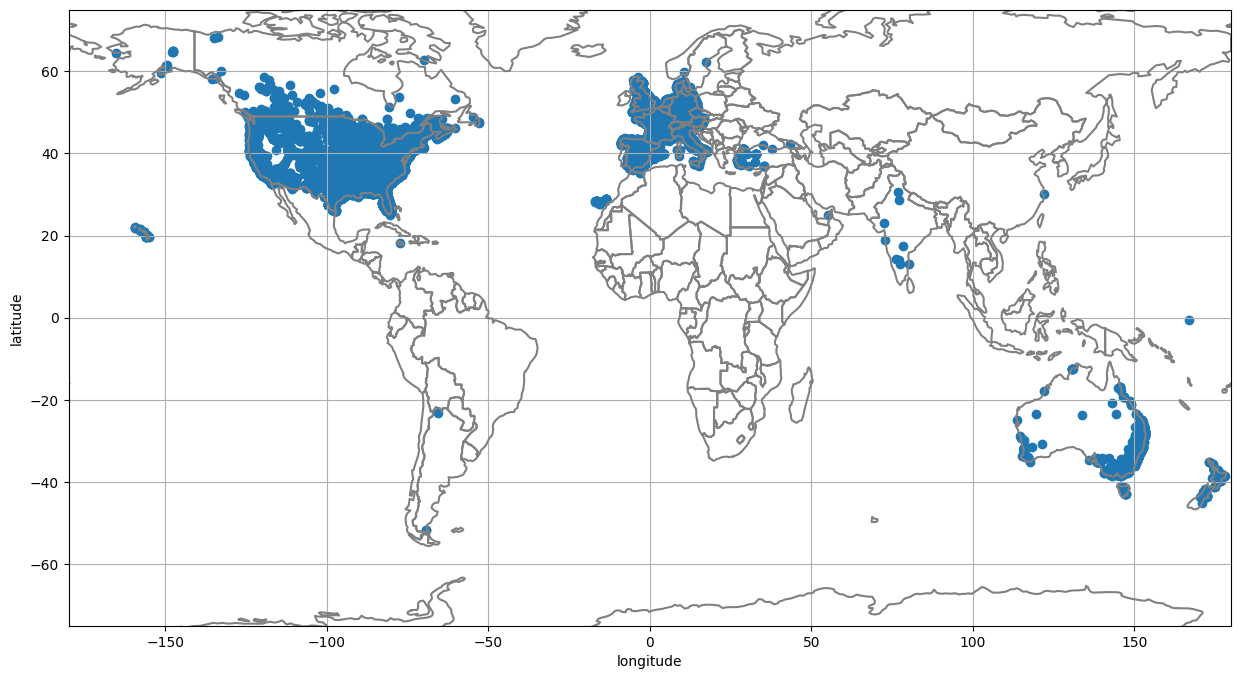

In [4]:
draw_earth(ylim=(-75, 75))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.scatter(GEO[::step, 0], GEO[::step, 1])
plt.show()

## 0.1. [1 point] Ok. Let's prepare ourselves to read the data from the hard drive

We will prepare id-based shards (data will be distributed into equal files with ranges `[0..capacity-1], [capacity..2*capacity-1], ...`. Each shard will store `capacity` elements. Your task is to complete the implementation with `iterate_dataset` function.

In [5]:
import os

def split_shards(file, folder='shard', capacity=20000):
    if not os.path.exists(folder):
        os.mkdir(folder)
    with open(file, "rb") as f:
        dataset = pickle.load(f)
    nshards = len(dataset) // capacity
    if nshards * capacity < len(dataset):
        nshards += 1
    
    for i in range(nshards):
        with open(f"{folder}/{i}", 'wb') as f:
            part = dataset[i * capacity:(i+1)*capacity]
            pickle.dump(part, f)
    dataset = None
    gc.collect()            

    
def dataset_get(indices, folder='shard', capacity=20000) -> list:
    result = []
    groups = {}
    for i in indices:
        x = i // capacity
        if x not in groups:
            groups[x] = []
        groups[x].append(i)
    for x in groups:
        with open(f"{folder}/{x}", "rb") as f:
            sha = pickle.load(f)
            for i in groups[x]:
                row = sha[i % capacity]
                result.append(row)
    return result

# should return iterator, which goes through all elements, consequently opening files
# use ``yield`` operator to simplify your code
def iterate_dataset(items, folder="shard", capacity=20000):
    n_shards = (items + capacity - 1) // capacity
    for shard_id in range(n_shards):
        shard_path = os.path.join(folder, str(shard_id))
        with open(shard_path, 'rb') as file:
            shard = pickle.load(file)
            yield from shard



In [6]:
split_shards("./poi_sample01.pickle")

asserts:

In [7]:
i = 0
for r in iterate_dataset(N):
    i += 1

assert i == N

asserts:

In [8]:
import numpy as np

for i in [137, 40000, 600000]:
    assert np.allclose(GEO[i,:], dataset_get([i])[0][0], atol=5*1e-2), ""

In [9]:
dataset_get([1, 10, 1000234, N-1])

[([-58.4339539, -34.6028583],
  'CreationFlow, Professional, Computer Services. AR, Ciudad de Buenos Aires, Vera 15 3-B'),
 ([13.9706993103, 46.6813430786],
  'Bahnhof Ossiach-Bodensdorf. AT, Bodensdorf, '),
 ([-117.642377, 34.068324],
  'Industrial Labor Management, Professional, Management & Consulting. US, Ontario, 647 E E St'),
 ([28.0354352, -26.1470966],
  'ScoreGrid, Professional, Computer Services. ZA, Johannesburg, 158 Jan Smuts Avenue Rosebank')]

---

# And now the task!
Ok. We are ready to perform the following steps utilizing functions beyond:
1. Build **coordinate search index**. We will use it to obtain POI from the given region.
3. Implement **vector text embedding index** (Annoy, HNSW) to serve semantic queries.
3. Implement **geocoding** with cache. We will use it to obtain city coordinates.
4. Impement search for **double queries: town and location type**.

# 1. Create spacial index for points of interest

We will store dataset rows numbers as values, and coordinates as keys. Please use [KDtree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) or [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from sklearn.

## 1.1. [5 points] Build the index and return it

Implement the following functions. To get the full grade:
- `build_geospacial_index` should build and return a search tree object: KDTree or BallTree.
- `kNN` accepts a 2D-point, `k` neighbours parameter, and returns **approximate** `k` neighbours (they can be different from the real neighbours).
- `inRadius` accepts a 2D-point, L<sub>2</sub> `radius`, and returns points inside the radius. Clarification: for simplicity **radius is given in units of coordinates (degrees)**, not kilometers or meters.

In [10]:
from sklearn.neighbors import BallTree

def build_geospacial_index(points, leaf_size=5) -> BallTree:
    index = BallTree(points, leaf_size=leaf_size)
    return index

def kNN(query_point: list, k: int, index: BallTree) -> list:
    query_array = np.array([query_point])
    distances, indices = index.query(query_array, k)
    return list(indices[0])

def inRadius(query_point: list, r: float, index: BallTree) -> list:
    query_array = np.array([query_point])
    indices = index.query_radius(query_array, r)[0]
    return list(indices)

In [11]:
spaidx = build_geospacial_index(GEO)

In [12]:
test_id = 13

idx = kNN(GEO[test_id], 10, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

idx = inRadius(GEO[test_id], 0.0625, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

[13, 145, 351, 2178, 10783, 11968, 15497, 23285, 24681, 26327]
[13, 145, 351, 2178, 10783, 11968, 14229, 14999, 15497, 16282, 16505, 16642, 16702, 21021, 23285, 24681, 26327, 27584]


## 1.2. [4 points] Tricky assert

Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. Thus you can follow one of the strategies:
- a key (coordinateS) corresponds to multiple values. This may require additional data strictures.
- improve the data (coordinates) to avoid collisions (e.g. make sure they never coinside by adding insignificant noise)

Pass the assert to get full points.

In [13]:
# I added noise to the data, you can check the code block with the GEO construction above

points = [1966663, 1480877, 2126566]
for p in points:
    x = GEO[p, :]
    r = kNN(x, 1000, spaidx)
    assert (p in r), "Query did not return itself"

## 1.3. [Optional demo] How leaf size influences build and search speed?

Let us look at how parameter of leaf size affects speed of search and construction

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


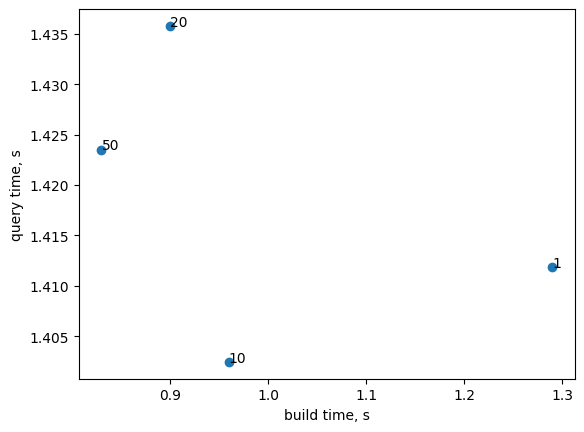

In [14]:
import random
import time
import matplotlib.pyplot as plt
import tqdm

queries = random.sample(range(N), 1000)
leaf_sizes = [1, 10, 20, 50]

build_times = []
query_times = []
for ls in tqdm.tqdm(leaf_sizes):
    start = time.time()
    idx = build_geospacial_index(GEO, ls)
    build_times.append(time.time() - start)
    
    start = time.time()
    for q in queries:
        d, r = spaidx.query([GEO[q]], 10000, sort_results=False, breadth_first=True)
    query_times.append(time.time() - start)
    idx = None
    gc.collect()

plt.xlabel("build time, s")
plt.ylabel("query time, s")
plt.scatter(build_times, query_times)
for i, ls in enumerate(leaf_sizes):
    plt.annotate(str(ls), (build_times[i], query_times[i]))

## 1.4. [5 points] Range queries?

Ok, you have a **radius query**, but what about **rectangual ranges**? Using the functions you already wrote, please, implement the range query given `north-east` and `south-west` corners. Pass the asserts to get points.

In [15]:
from sklearn.neighbors import KDTree

# Returns ids of the points in a rectangular range
def get_in_range(ne, sw, spacial_index, GEO) -> list:
    ne_arr, sw_arr = np.array(ne), np.array(sw)
    center = (ne_arr + sw_arr) / 2
    radius = np.linalg.norm(ne_arr - sw_arr) / 2

    # Use the inRadius function to get the indices of the points within the circle
    indices = inRadius(center, radius, spacial_index)

    # Filter out the points outside of the rectangle
    result = [idx for idx in indices if is_point_in_rectangle(GEO[idx], sw_arr, ne_arr)]

    # Sort the indices and return the result
    return sorted(result)

def is_point_in_rectangle(point, sw, ne) -> bool:
    return sw[0] <= point[0] <= ne[0] and sw[1] <= point[1] <= ne[1]


In [16]:
def print_starbucks(ids):
    for row in dataset_get(ids):
        if 'Starbucks' in row[1]:
            print(row[1])

asserts:

In [17]:
ids = get_in_range([-73.97, 40.75], [-74.03, 40.70], spaidx, GEO)

assert any(map(
            lambda x: 'Manhattan, 80 Delancey St' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks, Restaurant, . US, New York, 325 W 49 St
Starbucks, Restaurant, . US, Manhattan, 195 Broadway
Starbucks Coffee, Coffee & Tea, . US, Hoboken, 51 Newark St
Starbucks Coffee, Coffee & Tea, . US, New York, 450 W 33rd St
Starbucks Coffee, Coffee & Tea, . US, New York, 151 W 34th St
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks Coffee, Coffee & Tea, . US, New York, 1372 Broadway
Starbucks Coffee, Coffee & Tea, . US, New York, 1530 Broadway
Starbucks, Coffee & Tea, . US, Manhattan, 80 Delancey St
Starbucks, Coffee & Tea, . US, Manhattan, 471 Broadway
Starbucks, Coffee & Tea, . US, Manhattan, 280 Park Ave
Starbucks, Coffee & Tea, . US, Manhattan, 655 Lexington Ave


# 2. Geocoding

In this block we will learn, how to convert text place names into coordinate rectangles.

## 2.1. [5 points] Implement geocoding
which returns north-eastern and south-western points of the place. Pass asserts to get full points.

In [18]:
import requests

def get_town_range_coordinates(town: str) -> tuple:
    # I use openstreetmap API instead of google maps, because it is free and does not require API key
    api = 'https://nominatim.openstreetmap.org/search/{}?format=json&limit=1'
    response = requests.get(api.format(town))
    if response.status_code != 200:
        raise ValueError(f"Can't find town {town}")
    data = response.json()
    if len(data) == 0:
        raise ValueError(f"Can't find town {town}")
    data = data[0]
    NE = (float(data['boundingbox'][3]), float(data['boundingbox'][1]))
    SW = (float(data['boundingbox'][2]), float(data['boundingbox'][0]))
    return NE, SW


asserts:

In [19]:
p = get_town_range_coordinates('Pittsburgh downtown')
print(p)
assert p[1][0] <= -80. <= p[0][0] and p[1][1] <= 40.44 <= p[0][1] 

((-79.9849874, 40.4470976), (-80.0132624, 40.433983))


## 2.2. [5 points] Town queries

Now, having a range query and geocoding, we can implement town-queries! Pass the assert to get the points.

In [20]:
def get_in_town(town, index, GEO) -> list:
    NE, SW = get_town_range_coordinates(town)
    return get_in_range(NE, SW, index, GEO)

In [21]:
ids = get_in_town('Pittsburgh downtown', spaidx, GEO)

assert any(map(
            lambda x: 'US, Pittsburgh, 810 River Ave' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Pittsburgh, 810 River Ave
Starbucks Coffee, Utilities, Mobile Phone. US, Pittsburgh, 1719 Penn Ave


## 2.3. [5 points] Caching

Why should you pay for every geocaching request, if you can cache them? Implement a cached version on geocoding. The second query does not use internet.

In [22]:
GEO_CACHE = {}

def get_town_range_coordinates_cached(town: str) -> tuple:
    global GEO_CACHE
    if town not in GEO_CACHE:
        GEO_CACHE[town] = get_town_range_coordinates(town)
    else:
        print("Cache hit!")
    return GEO_CACHE[town]


def get_in_town_cached(town: str, index, GEO) -> list:
    NE, SW = get_town_range_coordinates_cached(town)
    return get_in_range(NE, SW, index, GEO)

In [23]:
ids = get_in_town_cached('Boulder, CO', spaidx, GEO)
print_starbucks(ids)
ids = get_in_town_cached('Boulder, CO', spaidx, GEO)
print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St
Cache hit!
Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St


# 3. Text search

We are done with geography, but we have no clear method to search for categories. What if we prepare vector index of location names?

In [24]:
import spacy
nlp = spacy.load('en_core_web_md')
names = {} #Changed from list to dict to optimize the search time

## 3.1. [5 points] Embedding

Here is the trick. If you use any embedding model "as it is", it may take some hours to prepare 2M embeddings. It's ok if you can wait (and get **2 points**), but...

To get full points, please think, how you can speed up the process with embedding to less than 5 minutes?

HINT: spacy model `nlp` has a [dictionary for word embeddings](https://spacy.io/api/vocab). You can access `nlp.vocab[word].vector` to get word embedding, `nlp.vocab.strings` map stores integer indices. Or maybe you want to use `fasttext` instead?

In [25]:
from nltk.tokenize import word_tokenize

with open('./words.txt', 'r') as f:
    names = {word.strip().lower() for word in f.readlines()}

def embed(text, nlp):
    names = nlp.vocab.strings
    result = np.zeros((300))
    text = text.lower()
    
    for word in word_tokenize(text):
        if word in names:
            result += nlp.vocab[word].vector
    
    if np.count_nonzero(result) == 0:
        if text in names:
            v = nlp(text).vector
            return v / np.linalg.norm(v)
        else:
            return None
    
    return result / np.linalg.norm(result)



In [26]:
from tqdm import tqdm
import gc
import numpy as np

embeddings = np.zeros((N, 300), dtype=np.float16)

for i, item in enumerate(tqdm(iterate_dataset(N), total=N)):
    name = item[1].split('.')[0]
    emb = embed(name, nlp)
    if emb is not None:
        embeddings[i, :] = emb

  0%|          | 0/2173512 [00:00<?, ?it/s]/tmp/ipykernel_316197/1966908270.py:18: RuntimeWarning: invalid value encountered in divide
  return v / np.linalg.norm(v)
100%|██████████| 2173512/2173512 [04:37<00:00, 7832.30it/s] 


## 3.2. [10 points] Vector index

Here you build vector index for our embeddings. I want to warn Windows users, that they can observe problems with installing Faiss and HNSWlib (please refer to the corresponding lab). Still this is not the reason not to try :)
Choose **one of the libraries** and fulfill the requirements to get full points:
1. If you choose [FAISS](https://faiss.ai/). Get started with [installation](https://faiss.ai/#install) and this [tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started). To get full points your index must use [Product Quantization](https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint): 50 subvectors, 8 bits (1 byte) each. Use custom `nprobe` parameter equal to 23. Number or Voronoi cells is `65536`. Refer to [this document](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#if-1m---10m-ivf65536_hnsw32) to understand recommendations.
2. If you use [HNSWlib](https://github.com/nmslib/hnswlib) (or [nmslib](https://github.com/nmslib/nmslib)) then follow these requirements. Use `cosine` metric for index construction, maximum number of outgoing connections (max outdegree) in the graph is 16, `ef` parameter at construction time should be `250`. Some useful information is given [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).
3. For [Annoy](https://github.com/spotify/annoy) you should use cosine distance for the space (if vectors are normed, you can use dot product intead), use all CPU cores at construction time. Build the index right on the disk, then load. Your index should consist of 37 trees.

**NB** If you run on not-very-modern hardware (e.g. your RAM is less then 8GB), then you'd better reduce dataset size (e.g. take a specific region only like US east cost). You can also reduce other parameters only for the sake of RAM efficiency, but please specify and justify your decisions.

e.g.
```    
roi = set(get_in_range([-68.645945, 43.163175], [-80.461502, 37.097044], spaidx, GEO))
```


**HINT** You can remove `embeddings` array and call `gc.collect()` before loading index to RAM.

**HINT2** Should you index vectors with $[0]^N$ values?

In [27]:
embedding_index = None

In [28]:
import os
from annoy import AnnoyIndex
import gc

def get_vector_index():
    if not os.path.exists('index.ann'):
        global embeddings
        index = AnnoyIndex(len(embeddings[0]), 'dot')
        index.on_disk_build('index.ann')
        for i, emb in enumerate(tqdm(embeddings)):
            index.add_item(i, emb)
        embeddings = None
        gc.collect()
        index.build(37, -1)
    else:
        index = AnnoyIndex(len(embeddings[0]), 'dot')
        index.load('index.ann')
    return index

def get_kNN_embeddings(embedding, k, index):
    return index.get_nns_by_vector(embedding, k)

In [29]:
embedding_index = get_vector_index()

100%|██████████| 2173512/2173512 [01:05<00:00, 33406.86it/s]


In [30]:
result = get_kNN_embeddings(embed('pharmacy', nlp), 1000, embedding_index)
assert len(result) == 1000

# 4. [5 points] And now we want to have this together!

Say no more:

In [31]:
def find(town, query) -> list:
    # Get embeddings for query and find locations within a radius of 1000
    query_embeddings = embed(query, nlp)
    kNN_embeddings = get_kNN_embeddings(query_embeddings, 1000, embedding_index)
    query_locations = set(kNN_embeddings)

    # Get Points of Interest (POIs) within the given town
    POIs_in_town = set(get_in_town(town, spaidx, GEO))

    # Get the intersection of POIs in town and query locations
    POIs_in_query = POIs_in_town.intersection(query_locations)

    # Return the POI dataset
    return dataset_get(POIs_in_query)


In [32]:
#changed manhatten downtown to manhattan, because the OSM API does not recognize the first one
items = find('Manhattan', 'hospital')
print(items[:20])
xy = np.array([row[0] for row in items])


[([-73.953539, 40.682034], 'Brooklyn Hospital Ctr, Health Services, Hospital. US, Brooklyn, 1221 Bedford Ave'), ([-74.008935, 40.71752], 'Care Facility, Health Services, Clinic. US, New York, 44 Hudson St'), ([-73.981776, 40.747441], 'Beth Israel Hospital, Health Services, Hospital. US, New York, 55 E 34 St'), ([-73.9793, 40.689401], 'The Brooklyn Hospital Center, Health Services, Hospital. US, Brooklyn, 19 Rockwell Place'), ([-73.987514, 40.756284], 'Hospital Audiences, Health Services, Hospital. US, New York, 220 W 42nd Street'), ([-73.97852, 40.691775], 'Brooklyn Hospital Center The, Health Services, Hospital. US, Brooklyn, 240 Willoughby St Ste 2'), ([-73.977642, 40.689811], 'The Brooklyn Hospital Center, Health Services, Hospital. US, Brooklyn, 121 Dekalb Ave'), ([-73.912052, 40.843475], 'Bronx Lebonon Hospital, Health Services, Hospital. US, Bronx, 1645 Grand Concourse'), ([-73.989695, 40.726171], 'East Village Foot Care Center, Health Services, Doctor. US, New York, 96 E 4th Str

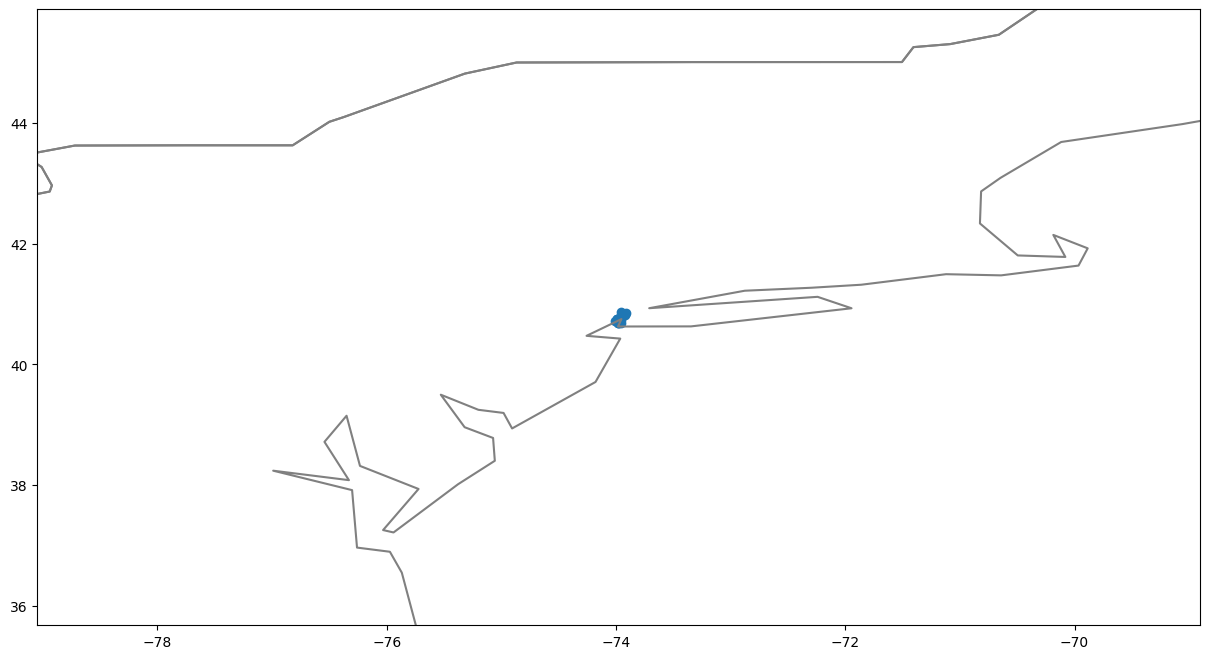

In [33]:
NE, SW = get_town_range_coordinates_cached('Manhattan')
draw_earth(xlim=(SW[0] - 5, NE[0] + 5), ylim=(SW[1] - 5, NE[1] + 5))
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()